In [2]:
import crocoddyl as croc
import pinocchio as pin
import numpy as np
import example_robot_data

robot = example_robot_data.loadDoublePendulum()
robot.initViewer(loadModel=True)

In [3]:
q0 = [3.14, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

robot.viewer.gui.refresh()

In [2]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
uRegCost = CostModelControl(robot.model, nu = 1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.array([1,1,1,1]+[0.1]*2))) 

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

# runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-3, cost=uRegCost)
runningCostModel.addCost(name="pend", weight=1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=1e5, cost=xPendCost)

In [3]:
actModel = ActuationModelDoublePendulum(robot.model, actLink=2)
runningModel = IntegratedActionModelEuler(DifferentialActionModelActuated(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelActuated(robot.model, actModel, terminalCostModel))

In [4]:
# Defining the time duration for running action models and the terminal one
dt = 1e-2
runningModel.timeStep = dt

T = 100
x0 = np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [2]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

us0 = np.zeros([T,1])
xs0 = [problem.initialState+0.1]*len(ddp.models())

ddp.solve(init_xs=xs0,init_us=us0,maxiter=150)

NameError: name 'SolverFDDP' is not defined

In [1]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

NameError: name 'displayTrajectory' is not defined

In [13]:
import time 
dt = 0.01
t = np.arange(0,1,dt)
q0 = np.array([[3.14,0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

In [14]:
nle = np.zeros([2,1])
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros([2,1])
    tau = np.zeros([2,1])
    tau[1,0] = ddp.us[i]
    nle[:,0] = m2a(robot.data.nle)    
    r[:] = tau - nle
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    #pin.forwardKinematics(robot.model, robot.data, q, q_d)
    robot.display(q)
    time.sleep(dt)

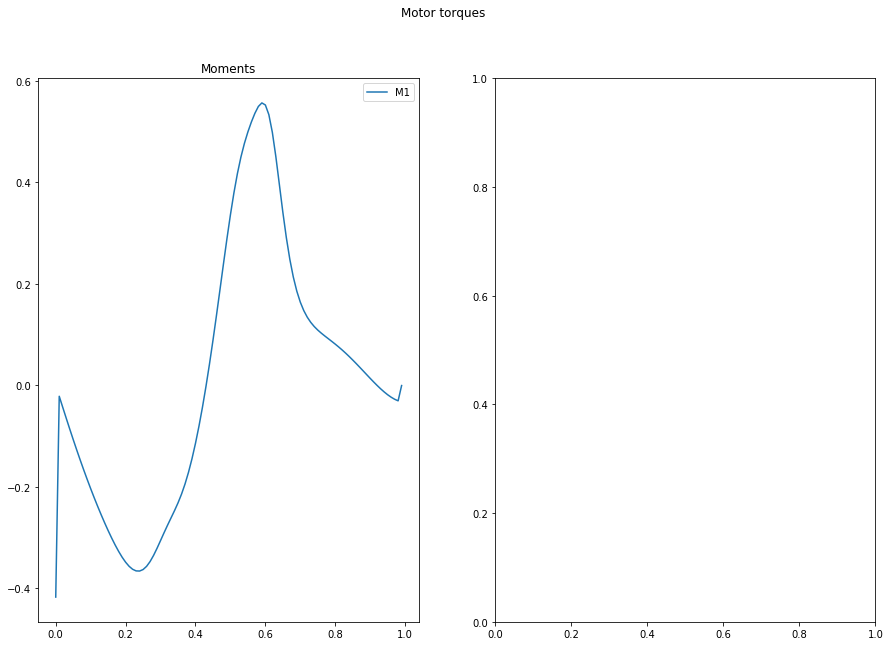

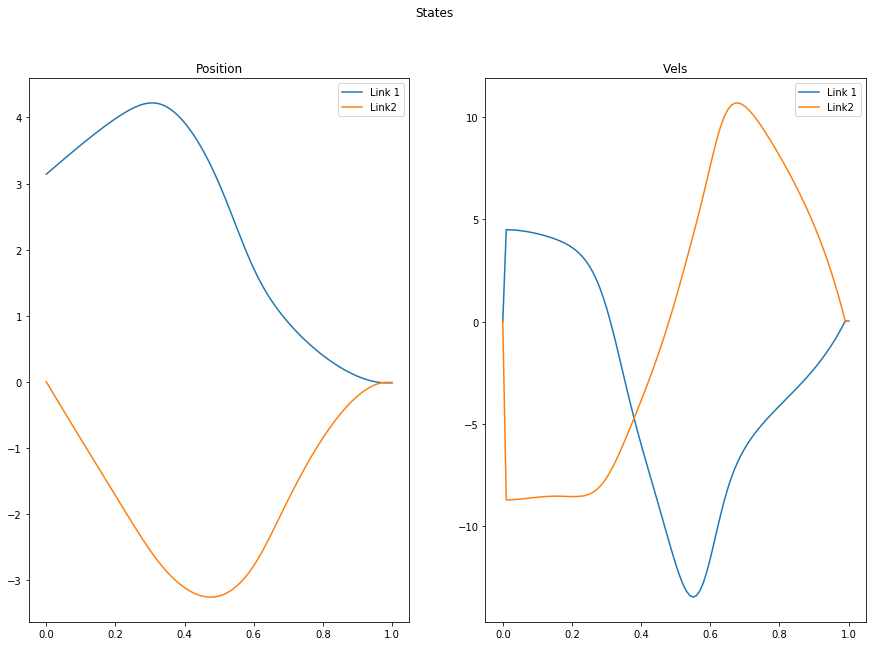

In [28]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = np.append(t, t[-1]+dt)
state = np.vstack(ddp.xs)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('States')
axs[0].plot(t_state,state[:,0], t_state, state[:,1])
axs[0].set_title('Position')
axs[0].legend(['Link 1','Link2'])
axs[1].plot(t_state,state[:,2], t_state, state[:,3])
axs[1].set_title('Vels')
axs[1].legend(['Link 1','Link2'])